#### 1. Imports

In [1]:
# --- Imports base ---
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
import seaborn as sns
sns.set(style="whitegrid")

#### 2. Paths & Data Loading

In [2]:
# --- Paths ---
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_2"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(10, 2), y:(10,)


#### 3. Add Weekly Data

In [3]:
# --- Weekly results ---
week_data = [
    (np.array([0.728919, 0.008403]),  0.4418679227641883),  # W1
    (np.array([0.684763, 0.992806]),    0.6397916079538416), # W2
    (np.array([0.966811, 0.862665]),   -0.0025378366827418716), # W3
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(13, 2), y:(13,)


#### 4. Quick Visualization

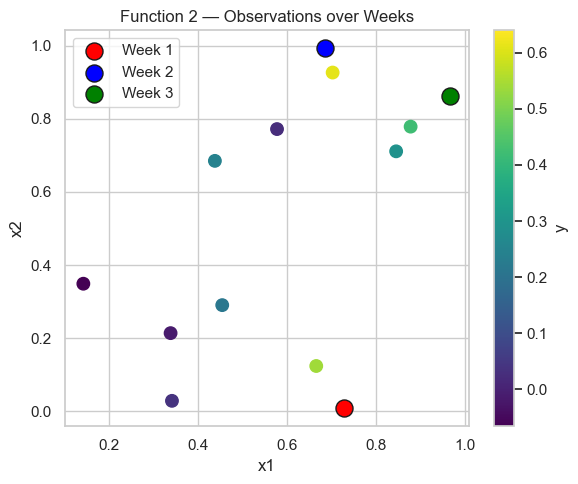

In [4]:
plt.figure(figsize=(6,5))
sc = plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=80)
plt.colorbar(sc, label='y')

# Weeks
plt.scatter(week_data[0][0][0], week_data[0][0][1],
            c='red', s=150, edgecolors='k', label='Week 1')
plt.scatter(week_data[1][0][0], week_data[1][0][1],
            c='blue', s=150, edgecolors='k', label='Week 2')
plt.scatter(week_data[2][0][0], week_data[2][0][1],
            c='green', s=150, edgecolors='k', label='Week 3')

plt.xlabel('x1'); plt.ylabel('x2')
plt.title('Function 2 — Observations over Weeks')
plt.legend(); plt.tight_layout(); plt.show()

#### 5.1 Gaussian Process Model

In [7]:
# --- 5) Gaussian Process surrogate (fit) ---

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C

# Kernel estable para 2D (ARD + ruido)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.3, 0.3], nu=2.5,
                                      length_scale_bounds=(1e-3, 3.0)) \
         + WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-6, 1e-1))

gp = GaussianProcessRegressor(kernel=kernel,
                              normalize_y=True,
                              n_restarts_optimizer=12,
                              random_state=0)
gp.fit(X, y)
print("Fitted kernel (F2):", gp.kernel_)

Fitted kernel (F2): 0.92**2 * Matern(length_scale=[0.0549, 3], nu=2.5) + WhiteKernel(noise_level=0.00883)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


6) Acquisition (EI) + Trust Region 

In [8]:
# --- 6) Acquisition: Expected Improvement (EI) with TR around Week 2 ---

import numpy as np
from scipy.stats import norm

# Helpers
def lhs(lb, ub, n, seed):
    rng = np.random.default_rng(seed)
    U = rng.random((n, lb.size))
    return lb + U * (ub - lb)

def too_close_Linf(c, X, tol=0.02):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# Dominio y TR
lb, ub = np.zeros(2), np.ones(2)
anchor = week_data[1][0]   # Week 2 input (mejor observado hasta ahora)
L = 0.30                   # TR relativamente estrecha para refinar
lb_tr = np.clip(anchor - 0.5 * L * (ub - lb), 0, 1)
ub_tr = np.clip(anchor + 0.5 * L * (ub - lb), 0, 1)

# Candidatos: 75% TR + 25% global
C_tr = lhs(lb_tr, ub_tr, n=24000, seed=2201)
C_gl = lhs(lb,    ub,    n=8000,  seed=2202)
Cands = np.vstack([C_tr, C_gl])

# Predicción GP
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# EI (más explotación tras W2 buena)
y_best = y.max()
xi = 0.02   # <- si quieres aún más explotación: 0.01
imp = mu - y_best - xi
Z = imp / sigma
ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# Anti-borde + anti-duplicado
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

order = np.argsort(-ei_masked)
x_next = None
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X, tol=0.02):
        x_next = cand
        break

# Resultado
print("Suggested next (F2, W4):", x_next)
print("Submission format:")
print(f"{x_next[0]:.6f} - {x_next[1]:.6f}")

# Checks rápidos
print("Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("Near-duplicate (L_inf<0.02)? ", too_close_Linf(x_next, X, tol=0.02))

Suggested next (F2, W4): [0.69048597 0.06964866]
Submission format:
0.690486 - 0.069649
Within [0,1]?  True
Near-duplicate (L_inf<0.02)?  False


## Reflection — Function 2

### Week 1
- The first query explored the lower-right corner of the search space `(x1 ≈ 0.73, x2 ≈ 0.01)`.  
- The output (`y ≈ 0.44`) was moderately positive but far from optimal, suggesting potential for improvement.  
- **Strategy:** expand exploration, as the response surface seems non-linear with multiple peaks.  
- **Next step:** keep `ξ ≈ 0.05` to encourage broader sampling and avoid premature convergence.

---

### Week 2
- A clear improvement was achieved (`y ≈ 0.64`) at `(x1 ≈ 0.68, x2 ≈ 0.99)`.  
- The model identified a high-performing region in the upper part of the domain — possibly close to the global maximum.  
- **Strategy:** shift towards exploitation and refine predictions near this promising area.  
- **Parameters:** `ξ ≈ 0.03`, Trust Region centered on Week 2 point (`L ≈ 0.35`).

---

### Week 3
- The third query produced a drop in performance (`y ≈ -0.0025`), meaning the candidate moved away from the optimal region.  
- The model likely **over-explored**, given the large TR and moderate ξ used in Week 3.  
- **Strategy for Week 4:** reduce exploration and focus on local refinement near Week 2’s optimum.  
- **Parameters:** tighter TR (`L ≈ 0.25–0.30`), lower `ξ ≈ 0.02`, and maintain ~25% global candidates for safety.